In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import json
import sklearn
from sklearn.model_selection import train_test_split
import joblib

# imports for KNN
from sklearn.neighbors import KNeighborsClassifier

#imports for LSTM
from numpy import zeros, newaxis
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras import regularizers
from keras import Input
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed, Dropout

In [ ]:
"""
Data Preprocessing
"""
# Date=0, Time=1, Outside Temp=2, Outside Humidity=3, AC_TEMP=4, INTERNAL_TEMP=5, AI_CHANGE=6, USER_CHANGE=7, DAY_OF_WEEK=8, SEASON=9
#set constants
USER_TYPE = ["worker", "student", "senior_citzen"]
NOISE_TYPE = ["small", "mid", "large"]
PETS = [True, False]
PLANTS = [True, False]
SLEEP_TEMP = [x for x in range(60, 68)]
NOISE = {"small" : random.uniform(-1, 1), "mid" : random.uniform(-1, 2), "large" : random.uniform(-2, 3)}
DOTW_MAP = {"Monday" : 0, "Tuesday" : 1, "Wednesday" : 2, "Thursday" : 3, "Friday" : 4, "Saturday" : 5, "Sunday" : 6}
# 1-winter 2-spring 3-summer 4-fall
SEASONAL_TEMP = {1: 68, 2: 75, 3: 78 , 4: 72}


# convert to celsius
def ftc(temp):
  return (temp - 32) * 5/9
# convert to fahrenheit
def ctf(temp):
  return temp * 9/5 + 32

#set internal temp
def set_internal_temp(row, data, user_profile):
  col, factor = (2, "external_temp") if data[row,4] == -99 else (4, "ac_temp")
  if row == 0:
    data[row,5]= data[row, col]
  else:
    delta = (data[row, col] - data[row-1,5]) / (user_profile["insolation_time"][factor]*60)
    data[row,5] = data[row-1,5] + delta

#format data
def format_data(data_df):
  data_df.columns = ['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 
                      'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE', 'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 
                      'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG', 'WIND_1_5', 'WIND_FLAG']
  #drop useless columns
  data_df.drop(['WBANNO', 'LST_DATE', 'LST_TIME','CRX_VN','PRECIPITATION', 'SR_FLAG', 'SOLAR_RADIATION', 'SURFACE_TEMPERATURE', 
                  'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'LONGITUDE', 'LATITUDE', 'ST_TYPE', 'ST_FLAG', 'RH_FLAG', 'WETNESS', 
                  'WET_FLAG', 'WIND_1_5', 'WIND_FLAG'], axis=1, inplace=True)
  #rename columns
  data_df.rename(columns={"AIR_TEMPERATURE" : "EXTERNAL_TEMP"}, inplace=True)
  data_df.rename(columns={"RELATIVE_HUMIDITY" : "OUTSIDE_HUMIDITY"}, inplace=True)
  data_df.rename(columns={"UTC_DATE" : "DATE"}, inplace=True)
  data_df.rename(columns={"UTC_TIME" : "TIME"}, inplace=True)
  #format date and time
  unformated_date_time = data_df[['DATE', 'TIME']].to_numpy()
  data_df['DATE'] = data_df['DATE'].apply(lambda x: '{0:0>8}'.format(x))
  data_df['DATE'] = pd.to_datetime(data_df['DATE'], format='%Y%m%d')
  data_df['TIME'] = data_df['TIME'].apply(lambda x: '{0:0>4}'.format(x))
  data_df['TIME'] = pd.to_datetime(data_df['TIME'], format='%H%M').dt.time
  return data_df.to_numpy(), unformated_date_time


#save processed data
def save_data(data, user_profile, to_np=True):
  #store processed data as csv
  processed_data = pd.DataFrame(data, columns=["Date", "Time", "External Temp", "Outside Humidity", "AC Temp", "Internal Temp", "AI Change", "User Change", "Day of Week", "Season"])
  # types of data as int or float
  processed_data = processed_data.astype({"Date": int, "Time": int, "External Temp": float, "Outside Humidity": float, "AC Temp": float, "Internal Temp": float, "AI Change": int, "User Change": int, "Day of Week": int, "Season": int})
  # create folders for batches
  if not os.path.exists('batches/weeks'):
    os.makedirs('batches/weeks')
  if not os.path.exists('batches/months'):
    os.makedirs('batches/months')
  if not os.path.exists('batches/years'):
    os.makedirs('batches/years')
  if not os.path.exists('batches/user_profiles'):
    os.makedirs('batches/user_profiles')
  #save data as csv
  processed_data.to_csv(f'batches/user_profiles/processed_data_{user_profile["user_type"]}.csv', index=False)
  # save data in week, month and year batches (288 rows per day)
  if to_np:
    processed_data = processed_data.to_numpy()
    np.save(f'batches/years/year.npy', processed_data)
    for i in range(0, len(processed_data), 288):
      week = processed_data[i:i+288*7]
      month = processed_data[i:i+288*30]
      if len(week) == 2016:
        np.save(f'batches/weeks/week{i}.npy', week)
      if len(month) == 8640:
        np.save(f'batches/months/month{i}.npy', month)
  else:
    processed_data.to_csv(f'batches/years/year.csv', index=False)
    for i in range(0, len(processed_data), 288):
      week = processed_data[i:i+288*7]
      month = processed_data[i:i+288*30]
      if len(week) == 2016:
        week.to_csv(f'batches/weeks/week{i}.csv', index=False)
      if len(month) == 8640:
        month.to_csv(f'batches/months/month{i}.csv', index=False)
  #save user profile as txt
  with open(f'batches/user_profiles/user_profile_{user_profile["user_type"]}.txt', 'w') as f:
    f.write(json.dumps(user_profile))
  return

  
#generate random day events
def gen_intervals(first_event, num_events, noise_type):
  for i in range(num_events+2):
    end_value = 0
    if i == 0: # first block is sleep
      start, end = -1, 6
    elif i == 1: # next blocks are work
        start, end = max(first_event[0] , end_value), first_event[1]
    elif i == num_events+1: # last block is sleep
      start, end = max(22, end_value) , float('inf')
    #random intervals within bounds
    noise = NOISE[noise_type]
    start_value = int(min(23,max(random.uniform(start-noise, start+noise), 0)))
    end_value = int(min(23,max(random.uniform(end-noise, end+noise), 0)))
    #catch errors
    if start_value == end_value and start_value == 23:
      start_value, end_value = start_value-1, end_value
    elif start_value == end_value:
      start_value, end_value = start_value, end_value+1
    start = end +2 
    end = start + random.randint(2, 3)
    yield (start_value, end_value)
    
#generate random profile
def gen_user_profile(user_type=None, noise_type=None, pets=None, plants=None, insolation_time_ac= None, insolation_time_external = None, schedule_cycle=None):
  profile = { "user_type" : user_type if user_type else random.choice(USER_TYPE),
              "noise_type" : noise_type if noise_type else random.choice(NOISE_TYPE),
              "pets" : pets if pets else random.choice(PETS),
              "plants" : plants if plants else random.choice(PLANTS),
              "sleep_temp": random.choice(SLEEP_TEMP),
              "insolation_time":{"ac_temp": insolation_time_ac if insolation_time_ac else random.uniform(1, 0.1), 
                                 "external_temp":insolation_time_external if insolation_time_external else random.uniform(1, 0.1)}}
  num_days = schedule_cycle if schedule_cycle else 7
  #monday=0, tuesday=1, wednesday=2, thursday=3, friday=4, saturday=5, sunday=6
  schedule = []
  for day in range(num_days):
    first_event = (7,10)
    num_events = random.randint(1, 4)
    gen_day = list(gen_intervals((7,16), 1, profile["noise_type"])) if profile["user_type"] == "worker" and day%7 < 5 else list(gen_intervals(first_event, num_events, profile["noise_type"]))
    if  profile["user_type"] == "student":
      if day%7 in (5,6):
        day_schedule = gen_day
      elif day%7 in (1,3):
        day_schedule = gen_day if day%7 == 1 else copy_tuesday
        copy_tuesday = day_schedule
      elif day%7 in (0,2,4):
        day_schedule = gen_day if day%7 == 0 else copy_monday
        copy_monday = day_schedule
    else:
      day_schedule = gen_day
    schedule.append(day_schedule)

  profile["schedule"] = schedule
  return profile


#process data
# Date=0, Time=1, External_Temp=2, Outside Humidity=3, AC_TEMP=4, INTERNAL_TEMP=5, AI_CHANGE=6, USER_CHANGE=7, DAY_OF_WEEK=8, SEASON=9
def process_data(filename,user_profile):
  # load txt data
  raw_data_df = pd.read_csv(filename+'.txt', sep='\s+', header=None)

  #convert raw_data to numpy array data
  data, unformated_date_time = format_data(raw_data_df)
  #add new columns on end
  data = np.hstack((data, np.full((len(data), 6), None)))
  #initializes variables
  current_sleep_temp = ftc(user_profile["sleep_temp"])
  current_pet_temp = random.uniform(ftc(64), ftc(78))
  current_plant_temp = random.uniform(ftc(60), ftc(75))
  current_season_temp = ftc(SEASONAL_TEMP[data[0][0].month%12 // 3 + 1] + NOISE[user_profile["noise_type"]])
  current_ac_delay = user_profile["insolation_time"]["ac_temp"]*2 + 0.5*NOISE[user_profile["noise_type"]]
  day_index = DOTW_MAP[data[0,0].day_name()]
  event_stack = user_profile["schedule"][day_index]
  event_status = "starting"

  for row in range(len(data)):
    # set default values
    data[row,4:10] = [-99, -99, 0, 0, day_index, data[row,0].month%12 // 3 + 1]
    event = event_stack[0]
    #update values based on time
    if row != 0:
      if data[row,0].day != data[row-1,0].day:#new day
        day_index += 1
        event_stack = user_profile["schedule"][day_index%len(user_profile["schedule"])]
      if data[row,9] != data[row-1,9]: #new season
        current_season_temp = ftc(SEASONAL_TEMP[data[row,9]] + NOISE[user_profile["noise_type"]])
        current_plant_temp += NOISE[user_profile["noise_type"]]
      if data[row,0].month != data[row-1,0].month:#new month
        current_sleep_temp += NOISE[user_profile["noise_type"]]
        if data[row,0].month%3 == 0:
          current_pet_temp += NOISE[user_profile["noise_type"]]
    #check event status relative to time
    if event[0] == data[row,1].hour:
      event_status = "starting"
    elif event[0] < data[row,1].hour < event[1] - current_ac_delay:
      event_status = "happening"
    elif event[1]-current_ac_delay <= data[row,1].hour <= event[1]:
      event_status = "ending"
    elif event[1] < data[row,1].hour:
      if len(event_stack)>1:
        event_stack = event_stack[1:]
        event = event_stack[0]
        event_status = "starting" if event[0] == data[row,1].hour else "ending"

    #set ac temp based on current event
    if event[0] == 0 or event[1] == 23:#(sleep,23)(0, wake_up_time) 
      if event[0] == 0 and event_status == "ending":
        data[row,4] = current_season_temp
        data[row,7] = 1 if data[row,1].minute == 0 else 0
      else:
        data[row,4] = current_sleep_temp
        data[row,7] = 1  if (event[1],event_status,0)==(23,"starting",data[row,1].minute) else 0

    else: #(event_start, event_end)
      if event_status in ["starting", "happening"]:
        if user_profile["pets"] and user_profile["plants"]:
          data[row,4] = (current_pet_temp + current_plant_temp)/2
        elif user_profile["pets"] or user_profile["plants"]:
          data[row,4] = current_plant_temp if user_profile["plants"] else current_pet_temp
        else:
          data[row,4] = -99
        data[row,7] = 1 if (event_status,0)==("starting",data[row,1].minute) else 0
      elif event_status == "ending":
        data[row,4] = current_season_temp
        data[row,7] = 1 if (event[1]-current_ac_delay,0)==(data[row,1].hour,data[row,1].minute) else 0

    #set internal temp
    set_internal_temp(row, data, user_profile)
  #concat raw date time
  data = np.hstack((unformated_date_time[:,:], data[:,[2,3,4,5,6,7,8,9]]))
  # save data
  save_data(data, user_profile, to_np=False)
  return data


# plot data
def plot_data(processed_data_df, show_ac_temp=True, show_inside_temp=True, show_outside_temp=True, convert = True, time_type = "day"):
    x_axis_label = {"day": 288, "week": 7*288, "month": 288*7*4, "year": 288*52*7}
    # if ac temp is -99, replace 0
    processed_data_df = processed_data_df.replace(-99, 0)
    # filter outlines >-20
    processed_data_df = processed_data_df[processed_data_df['AC Temp'] > -20]
    processed_data_df = processed_data_df[processed_data_df['Internal Temp'] > -20]
    processed_data_df = processed_data_df[processed_data_df['External Temp'] > -20]
    # plot data
    y = None
    plt.figure(figsize=(20,10))
    if show_ac_temp:
        if convert:
          y = ctf(processed_data_df['AC Temp'][:x_axis_label[time_type]])
        else:
          y = processed_data_df['AC Temp'][:x_axis_label[time_type]]
        plt.plot(y, label="AC Temp", color="red")
    if show_inside_temp:
        if convert:
          y = ctf(processed_data_df['Internal Temp'][:x_axis_label[time_type]])
        else:
          y = processed_data_df['Internal Temp'][:x_axis_label[time_type]]
        plt.plot(y, label="Internal Temp", color="blue")
    if show_outside_temp:
        if convert:
          y = ctf(processed_data_df['External Temp'][:x_axis_label[time_type]])
        else:
          y = processed_data_df['External Temp'][:x_axis_label[time_type]]
        plt.plot(y, label="External Temp", color="green")
    plt.legend()
    plt.show()


In [ ]:
"""
READ ME

RUN TO GET DATA

"""
################################################################################
# 1st collect data from link and store in txt file named raw_data
#       Link: https://www.ncei.noaa.gov/access/crn/qcdatasets.html
#
# 2nd set user profile as desired: if None selection is random
#       user_type : "worker", "student", "senior_citzen" 
#       noise_type: "small", "mid", "large"
#       pets      : True, False
#       plants    : True, False
#       insolation_time_ac: 1-0 
#       insolation_time_external: 1-0
#       schedule_cycle: 1-356 (default 7)
#
# 3rd select batch size and set batch variable to specfic batch
#       e.g batch : week_batch, month_batch, year_batch
# 
# 3rd run this cell. 
################################################################################

"""EDIT ME"""
# generate random user profiles: EDIT ME
user_profile = gen_user_profile(user_type="students", 
                                noise_type="small", 
                                pets=False, 
                                plants = False,
                                insolation_time_ac=0.5, 
                                insolation_time_external=0.75,
                                schedule_cycle = 7)

#process data
processed_data = process_data("raw_data",user_profile)
#load data
week_batch = pd.read_csv("batches/weeks/week0.csv")
month_batch = pd.read_csv("batches/months/month0.csv")
year_batch = pd.read_csv("batches/years/year.csv")

"""
View Raw Data
"""

#convert txt to csv file
raw_data = pd.read_csv('raw_data.txt', sep='\s+', header=None)
raw_data.columns = ['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE', 'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG', 'WIND_1_5', 'WIND_FLAG']
raw_data.to_csv('raw_data.csv', index=False)

#read csv file
df = pd.read_csv('raw_data.csv')

df.head(80000)

,WBANNO,UTC_DATE,UTC_TIME,LST_DATE,LST_TIME,CRX_VN,LONGITUDE,LATITUDE,AIR_TEMPERATURE,PRECIPITATION,...,ST_TYPE,ST_FLAG,RELATIVE_HUMIDITY,RH_FLAG,SOIL_MOISTURE_5,SOIL_TEMPERATURE_5,WETNESS,WET_FLAG,WIND_1_5,WIND_FLAG
0,3739,20060301,1840,20060301,1340,1.301,-75.93,37.29,5.8,0.0,...,U,0,-9999,0,-99.0,-9999.0,1182,0,-99.0,0
1,3739,20060301,1845,20060301,1345,1.301,-75.93,37.29,6.0,0.0,...,U,0,-9999,0,-99.0,-9999.0,1186,0,-99.0,0
2,3739,20060301,1850,20060301,1350,1.301,-75.93,37.29,6.0,0.0,...,U,0,-9999,0,-99.0,-9999.0,1185,0,-99.0,0
3,3739,20060301,1855,20060301,1355,1.301,-75.93,37.29,5.6,0.0,...,U,0,-9999,0,-99.0,-9999.0,1169,0,-99.0,0
4,3739,20060301,1900,20060301,1400,1.301,-75.93,37.29,5.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1167,0,-99.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,3739,20061204,1255,20061204,755,1.301,-75.93,37.29,5.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1084,0,-99.0,0
79996,3739,20061204,1300,20061204,800,1.301,-75.93,37.29,5.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1085,0,-99.0,0
79997,3739,20061204,1305,20061204,805,1.301,-75.93,37.29,5.7,0.0,...,U,0,-9999,0,-99.0,-9999.0,1085,0,-99.0,0
79998,3739,20061204,1310,20061204,810,1.301,-75.93,37.29,5.6,0.0,...,U,0,-9999,0,-99.0,-9999.0,1077,0,-99.0,0


In [ ]:
"""
READ ME

RUN TO SPLIT DATA

"""
"""EDIT ME"""
#select batch size
batch = year_batch

#split tarining, validation, testing
dev, test = train_test_split(batch, test_size=0.2, shuffle=False)
train, val = train_test_split(dev, test_size=0.2, shuffle=False)
#split label
X_train, Y_train = train.drop(columns=["AC Temp"]), train["AC Temp"]
X_val, Y_val = val.drop(columns=["AC Temp"]), val["AC Temp"]
X_test, Y_test = test.drop(columns=["AC Temp"]), test["AC Temp"]

print(user_profile)

{'user_type': 'students', 'noise_type': 'small', 'pets': False, 'plants': True, 'sleep_temp': 62, 'insolation_time': {'ac_temp': 0.5, 'external_temp': 0.75}, 'schedule': [[(0, 6), (7, 9), (21, 23)], [(0, 5), (7, 10), (11, 13), (15, 19), (20, 22), (22, 23)], [(0, 5), (7, 10), (11, 15), (16, 18), (21, 23)], [(0, 6), (7, 10), (11, 15), (17, 18), (20, 23), (22, 23)], [(0, 6), (7, 9), (21, 23)], [(0, 5), (6, 9), (11, 14), (17, 18), (21, 23), (21, 23)], [(0, 6), (7, 9), (12, 14), (15, 18), (20, 22), (21, 23)]]}


In [ ]:
"""
View X Training Data
"""
X_train.head(288)

,Date,Time,External Temp,Outside Humidity,Internal Temp,AI Change,User Change,Day of Week,Season
0,20060301,1840,5.8,-9999.0,23.444199,0,0,2,2
1,20060301,1845,6.0,-9999.0,23.444199,0,0,2,2
2,20060301,1850,6.0,-9999.0,23.444199,0,0,2,2
3,20060301,1855,5.6,-9999.0,23.444199,0,0,2,2
4,20060301,1900,5.7,-9999.0,23.218281,0,0,2,2
...,...,...,...,...,...,...,...,...,...
283,20060302,1815,19.8,-9999.0,22.746910,0,0,3,2
284,20060302,1820,20.4,-9999.0,22.770153,0,0,3,2
285,20060302,1825,20.8,-9999.0,22.792621,0,0,3,2
286,20060302,1830,21.3,-9999.0,22.814340,0,0,3,2


In [ ]:

"""
View Y Training Data
"""
Y_train.head(20)

0     23.444199
1     23.444199
2     23.444199
3     23.444199
4     16.666667
5     16.666667
6     16.666667
7     16.666667
8     16.666667
9     16.666667
10    16.666667
11    16.666667
12    16.666667
13    16.666667
14    16.666667
15    16.666667
16    16.666667
17    16.666667
18    16.666667
19    16.666667
Name: AC Temp, dtype: float64

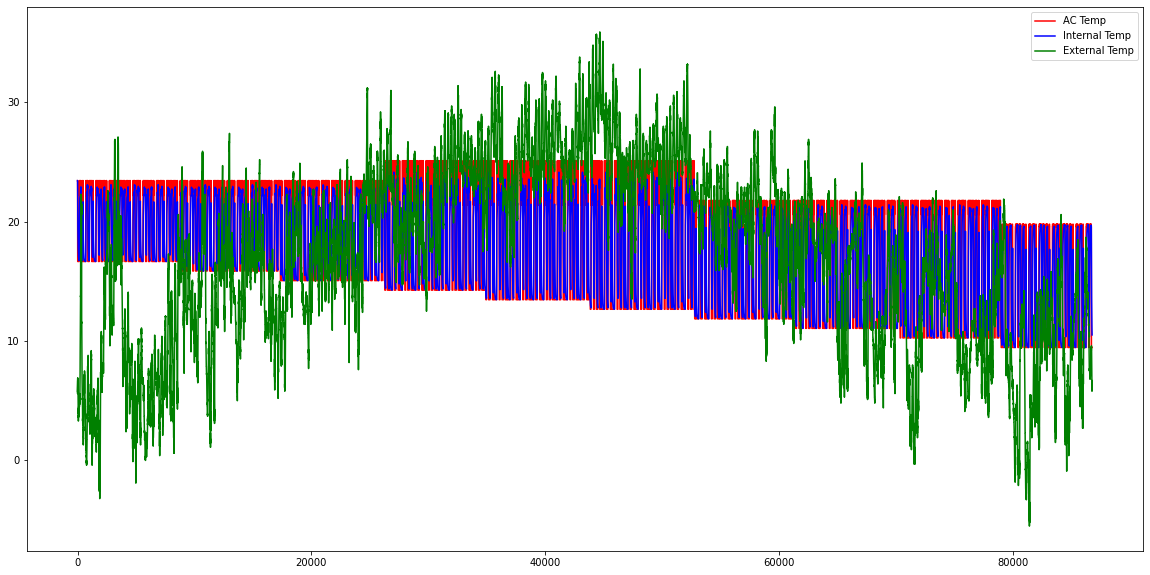

In [ ]:
"""
Plot Data
"""
time = "year"
plot_data(batch, show_ac_temp=True, show_inside_temp=True, show_outside_temp=True, convert = False, time_type = time)

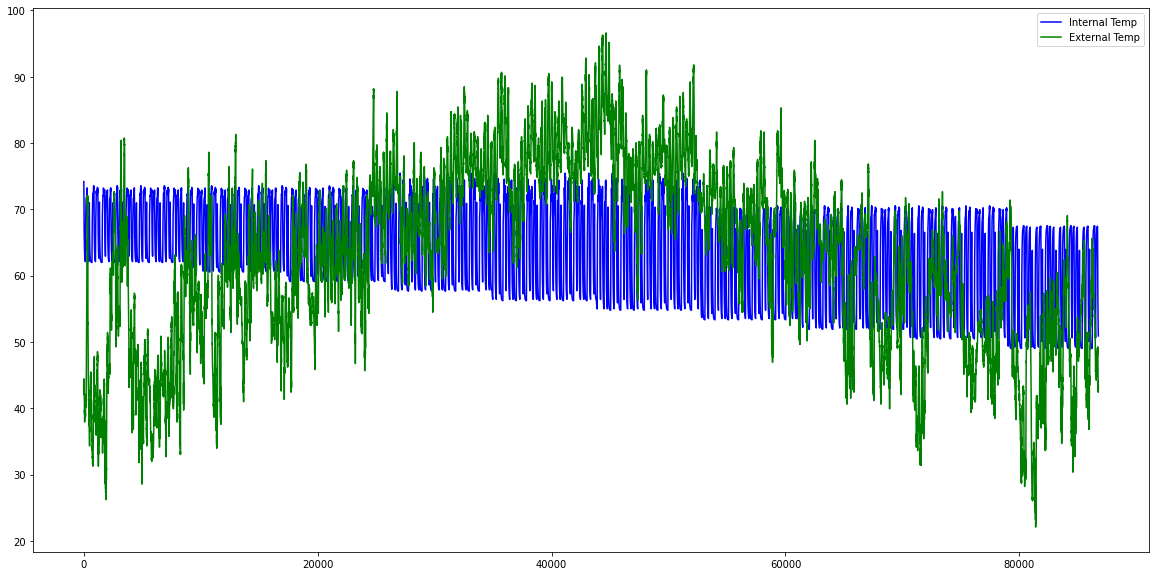

In [ ]:
plot_data(batch, show_ac_temp=False, show_inside_temp=True, show_outside_temp=True, convert = True, time_type = time)

In [ ]:
"""
Models:
  1. Random Forest (RF)
  2. Long Short Term Memory (LSTM)
  3. K Nearest Nieghbors (KNN)
"""

'\nModels:\n  1. Random Forest (RF)\n  2. Long Short Term Memory (LSTM)\n  3. K Nearest Nieghbors (KNN)\n'

In [ ]:
"""
Random Forest (RF)
"""
class Model_RF(): 
  def __init__(self):
    #create default model
    self.model = RandomForestClassifier()

  def train(self, hyper_parms): #TODO: add custom hyperparmeters
    #reset and train model
   
  
    self.model = RandomForestClassifier(max_features=hyper_parms['mf'], max_depth=hyper_parms['md'],min_samples_split=hyper_parms['msplit'],min_samples_leaf=hyper_parms['mleaf'],p=hyper_parms['p'])
    self.model.fit(X_train, Y_train.astype(int))
    return self.model

  def validate(self):
    #cross validate models acc
    acc = self.model.score(X_val, Y_val.astype(int))
    return acc

  def test(self):
    #test models acc
    acc = self.model.score(X_test, Y_test.astype(int))
    return acc

  def load(self, filename):
    # load model 
    self.model = joblib.load(filename)

  def save(self, filename):
    # save model
    joblib.dump(self.model, filename)

# create folder for models
if not os.path.exists('models/rf'):
  os.makedirs('models/rf')








    


In [ ]:
#Test Model Class
model = Model_RF()
rf_hyper_params = [{"name":"num_trees", "default":1, "start":1, "stop":5, "step":1}, 
                  {"name":"max_depth", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"max_features", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"min_node_cap", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"min_leaf_cap", "default":5, "start":5, "stop":10, "step":1}]
model.train() # Add parameters
acc = model.validate()
print(acc)
model.save('models/rf/rf_model_test.pkl')
saved_model = model.load('models/rf/rf_model_test.pkl')
print(saved_model)




TypeError: ignored

In [ ]:
from pandas.core.describe import describe_timestamp_as_categorical_1d
"""
Long Short Term Memory (LSTM)
"""

class Model_LSTM(): 
  def __init__(self):
    #create default model
    self.model = None
    self.train_data  = None
    self.train_label  = None
    self.val_data  = None
    self.val_label = None
    self.train_mean = None
    self.train_std = None

  def onc(self,data):
    # One hot coding for catagorial data (DOTW and Season)
    data['Day of Week'] = data['Day of Week']%7 #NEED FIX

    data['Day of Week'] = pd.Categorical(data['Day of Week'].astype(str),categories=['0','1','2','3','4','5','6'])
    data = pd.get_dummies(data, columns = ['Day of Week'])
    data['Season'] = pd.Categorical(data['Season'].astype(str),categories=['1','2','3','4'])
    data = pd.get_dummies(data, columns = ['Season'])

    return data

  def preprocess(self):
    #preprocess data
    self.train_data = X_train.copy()
    self.train_label = Y_train.copy()
    self.val_data = X_val.copy()
    self.val_label = Y_val.copy()

    # One hot coding for catagorial data (DOTW and Season)
    self.train_data = self.onc(self.train_data)
    self.val_data = self.onc(self.val_data)

    #drop date time column
    dt_col = ['Date','Time']
    self.train_data.drop(dt_col, axis=1, inplace=True)
    self.val_data.drop(dt_col, axis=1, inplace=True)
    
    #Normalize numeric data
    self.train_mean = self.train_data.mean()
    self.train_std = self.train_data.std()

    norm_col = ['External Temp','Internal Temp','Outside Humidity']
    self.train_data[norm_col] = (self.train_data[norm_col] - self.train_mean[norm_col]) / self.train_std[norm_col]
    self.train_label = (self.train_label - self.train_label.mean()) / self.train_label.std()
    self.val_data[norm_col] = (self.val_data[norm_col] - self.train_mean[norm_col]) / self.train_std[norm_col]
    self.val_label = (self.val_label - self.train_label.mean()) / self.train_label.std()
    

  def train(self, patience=2,batch_size = 64, epochs = 100): #TODO: add custom hyperparmeters
    #preprocess data
    self.preprocess()
    timesteps = 50
    
    #reshape data
    self.train_data = self.train_data.to_numpy()
    self.train_label = self.train_label.to_numpy()
    self.val_data = self.train_data[3000:4000,:]
    self.val_label = self.train_label[3000:4000]
    self.train_data = self.train_data[0:3000,:]
    self.train_label = self.train_label[0:3000]
    
    self.train_data = np.reshape(self.train_data,(self.train_data.shape[0],1,self.train_data.shape[1]))
    self.train_data = np.reshape(self.train_data,(int(self.train_data.shape[0]/timesteps),timesteps,self.train_data.shape[2]))
    self.train_label = np.reshape(self.train_label,(self.train_label.shape[0],1,1))
    self.train_label = np.reshape(self.train_label,(int(self.train_label.shape[0]/timesteps),timesteps,1))
    
    #self.val_data = self.val_data.to_numpy()
    #self.val_label = self.val_label.to_numpy()
    #self.val_data = self.val_data[0:16808,:]
    #self.val_label = self.val_label[0:16808]

    self.val_data = np.reshape(self.val_data,(self.val_data.shape[0],1,self.val_data.shape[1]))
    self.val_data = np.reshape(self.val_data,(int(self.val_data.shape[0]/timesteps),timesteps,self.val_data.shape[2]))
    self.val_label = np.reshape(self.val_label,(self.val_label.shape[0],1,1))
    self.val_label = np.reshape(self.val_label,(int(self.val_label.shape[0]/timesteps),timesteps,1))

    print(self.train_data.shape)
    print(self.train_label.shape)

    #train model
    self.model = Sequential(name="LSTM-Model") # Model
    #self.model.add(Input(batch_shape=(batch_size, timesteps, 1) , name='Input-Layer')) # Input Layer
    #self.model.add(Bidirectional(LSTM(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-LSTM-Encoder-Layer')) # Encoder Layer
    #self.model.add(RepeatVector(Y_train.shape[0], name='Repeat-Vector-Layer')) # Repeat Vector
    #self.model.add(Bidirectional(LSTM(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-LSTM-Decoder-Layer')) # Decoder Layer
    
    self.model.add(LSTM(batch_size, input_shape=(self.train_data.shape[1], self.train_data.shape[2]),
                        return_sequences=True))
    self.model.add(Dropout(0.2))
    self.model.add(Dense(units=1,activation='linear')) # Output Layer

    self.model.summary()

    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1, mode='min')

    self.model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = self.model.fit(self.train_data, self.train_label, epochs=epochs, batch_size = batch_size, validation_data=(self.val_data, self.val_label), verbose = 2,shuffle = False)

    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    return self.model

  def validate(self):
    #cross validate models acc
    acc = self.model.evaluate(self.val_data,self.val_label, batch_size=128)[1]
    prediction = self.model.predict(self.val_data)
    label = self.val_label
    plt.plot(prediction.flatten() )
    plt.plot(label.flatten())
    
    plt.title('accuracy')
    plt.legend(['prediction', 'actual'], loc='upper left')
    return acc

  def test(self, model):
    #test models acc
    acc = 0
    return acc

  def load(self, filename):
    # load model 
    self.model = load_model(filename)

  def save(self):
    # save model
    self.model.save(filename)

# create folder for models
if not os.path.exists('models/lstm'):
  os.makedirs('models/lstm')

In [ ]:
#Test Model Class
model = Model_LSTM()
model.train({}) ## add your parameters here
acc = model.validate()
print(acc)
#model.save('models/lstm/lstm_model_test.pkl')
#saved_model = model.load('models/lstm/lstm_model_test.pkl')
#print(saved_model)



(60, 50, 16)
(60, 50, 1)
Model: "LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 64)            20736     
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 50, 1)             65        
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 - 7s - loss: 0.3507 - mean_absolute_error: 0.4333 - val_loss: 0.2995 - val_mean_absolute_error: 0.4727 - 7s/epoch - 7s/step
Epoch 2/100
1/1 - 0s - loss: 0.3094 - mean_absolute_error: 0.4207 - val_loss: 0.2840 - val_mean_absolute_error: 0.4750 - 169ms/epoch - 169ms/step
Epoch

In [ ]:
"""
K Nearest Nieghbors (KNN)
"""

class Model_KNN(): 
  def __init__(self):
    #create default model
    self.model = KNeighborsClassifier()

  def train(self, hyper_parms): #TODO: add custom hyperparmeters
    #reset and train model
    self.model = KNeighborsClassifier(n_neighbors=hyper_parms['n_neighbors'], weights=hyper_parms['weights'],algorithm=hyper_parms['algorithm'],leaf_size=hyper_parms['leaf_size'],p=hyper_parms['p'])
    self.model.fit(X_train, Y_train.astype(int))
    return self.model

  def validate(self):
    #cross validate models acc
    acc = self.model.score(X_val, Y_val.astype(int))
    return acc

  def test(self):
    #test models acc
    acc = self.model.score(X_test, Y_test.astype(int))
    return acc

  def load(self, filename):
    # load model 
    self.model = joblib.load(filename)

  def save(self, filename):
    # save model
    joblib.dump(self.model, filename)

# create folder for models
if not os.path.exists('models/knn'):
  os.makedirs('models/knn')

In [ ]:
#Test Model Class
model = Model_KNN()
model.train({'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 30, 'p': 2})
acc = model.validate()
print(acc)
model.save('models/knn/knn_model_test.pkl')
saved_model = model.load('models/knn/knn_model_test.pkl')
print(saved_model)

0.4239968373196284
None


In [ ]:
"""
Model Training

"""

'\nModel Training\n\n'

In [ ]:
class Trainer():
    def run(self, model_type, hyper_params):
        results = { param["name"]: None for param in hyper_params}
        x, y = [],[]

        if model_type == "RF":
                model = Model_RF()
        elif model_type == "LSTM":
                model = Model_LSTM()
        elif model_type == "KNN":
                model = Model_KNN()
        
        for index, param in enumerate(hyper_params):
            #store default value before its updated
            default_value = hyper_params[index]["default"] 

            for value in range(param["start"], param["stop"], param["step"]):
                # current hyper-parameter value
                hyper_params[index]["default"] = value
                
                # train
                model.train(hyper_params)

                # validate
                accuracy = model.validate()
                # store value to list
                x.append(value)
                y.append(accuracy)

            #store list to results
            results[param["name"]] = (x,y)
            x, y = [],[]
            #reset default value
            hyper_params[index]["default"] = default_value

        self.plot_results(results)
      
    def plot_results(self, results):
      for x_param, (x,y) in results:
        plt.plot(x, y)
        plt.xlabel(x_param)
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs "+x_param)
        plt.show()


In [ ]:
model_type = "RF"
rf_hyper_params = [{"name":"num_trees", "default":1, "start":1, "stop":5, "step":1}, 
                  {"name":"max_depth", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"max_features", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"min_node_cap", "default":5, "start":5, "stop":10, "step":1}, 
                  {"name":"min_leaf_cap", "default":5, "start":5, "stop":10, "step":1}]

rf_trainer = Trainer()

In [ ]:
#TODO: LSTM and KNN
model_type = "LSTM"
lstm_hyper_params = [{"name":"ADD PARAMETER NAME HERE", "default":1, "start":1, "stop":5, "step":1}]
lstm_trainer = Trainer()

In [ ]:
model_type = "KNN"
#n_neighbors=hyper_parms['n_neighbors'], weights=hyper_parms['weights'],algorithm=hyper_parms['algorithm'],leaf_size=hyper_parms['leaf_size'],p=hyper_parms['p']
knn_hyper_params = [{"name":"ADD PARAMETER NAME HERE", "default":1, "start":1, "stop":5, "step":1,
                     "name":"ADD PARAMETER NAME HERE", "default":1, "start":1, "stop":5, "step":1,
                     }]
knn_trainer = Trainer()

In [ ]:
# tune model 

In [ ]:
model_type = "RF"
rf_hyper_params = [{"name":"n_estimators", "default":1, "start":1, "stop":5, "step":1},
                     {"name:"max_features", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"max_depth", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"min_samples_split", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"min_samples_leaf", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"p=2", "default":1, "start":1, "stop":5, "step":1}]
rf_trainer.run(model_type, rf_hyper_params)

In [ ]:
model_type = "LSTM"
lstm_hyper_params = [{"name":"n_neighbors", "default":1, "start":1, "stop":5, "step":1},
                     {"name:"weights", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"kd_tree", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"leafsize", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"n_neighbors", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"p=2", "default":1, "start":1, "stop":5, "step":1}]
lstm_trainer.run(model_type, lstm_hyper_params)

In [ ]:
model_type = "KNN"
knn_hyper_params = []{"name":"n_neighbors", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"weights", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"kd_tree", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"leafsize", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"n_neighbors", "default":1, "start":1, "stop":5, "step":1},
                     {"name":"p=2", "default":1, "start":1, "stop":5, "step":1}]
knn_trainer.run(model_type, knn_hyper_params)

In [ ]:
# test model

In [ ]:
# pick location, schedule -> view user AC schedule and AI predicted  and cost savings 
# nest themo stat
# dumb schedule
# compare cost

In [ ]:
"""
1st Prototype
"""
import pandas as pd
import numpy as np
import statistics
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import sklearn
import os
import glob

# Imports all CSV files found in current working directory
path = os.getcwd()
txt_files = glob.glob(os.path.join(path, "*.TXT"))

def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        if line not in content:
            f.write(line.rstrip('\r\n') + '\n' + content)

# Combines individual TXT's into one master data frame
for file in txt_files:
    temp = file.split("\\")
    line_prepender(temp[len(temp) - 1], "DATE,TIME,INTERNAL_TEMP,HUMIDITY,WALL_TEMP,AMBIENT_TEMP,COMFORT_LEVEL")
df_list = [pd.read_csv(f) for f in txt_files]
master_data = pd.concat(df_list) 
print(str(len(df_list)), 'file(s) read')

clean_data = master_data.copy()
clean_data['DATE'] = clean_data['DATE'].astype(str)
clean_data['COMFORT_LEVEL'] = clean_data['COMFORT_LEVEL'].astype(str)
clean_data['INTERNAL_TEMP'] = [float(x.split('°')[0]) for x in clean_data['INTERNAL_TEMP']]
clean_data['HUMIDITY'] = [float(x.split('%')[0]) for x in clean_data['HUMIDITY']]
clean_data['WALL_TEMP'] = [float(x.split('°')[0]) for x in clean_data['WALL_TEMP']]
clean_data['AMBIENT_TEMP'] = [float(x.split('°')[0]) for x in clean_data['AMBIENT_TEMP']]

clean_data['TIME'] = [datetime.strptime(x, '%H:%M:%S').time() for x in clean_data['TIME']]
clean_data['TIME_CATEGORICAL'] = [(x.hour % 24 + 4) // 4 for x in clean_data['TIME']]
clean_data['TIME_CATEGORICAL'].replace({ 1: 'Late Night',
                                         2: 'Early Morning',
                                         3: 'Morning',
                                         4: 'Noon',
                                         5: 'Evening',
                                         6: 'Night'}, 
                                inplace=True)

clean_data = clean_data[~(clean_data == 0).any(axis=1)]
clean_data

clean_data.corr()

clean_data['INTERNAL_TEMP'].hist()
clean_data['WALL_TEMP'].hist()
clean_data['AMBIENT_TEMP'].hist()
clean_data['HUMIDITY'].hist()
clean_data['TIME_CATEGORICAL'].hist()

#! pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = clean_data.drop(columns=['COMFORT_LEVEL', 'TIME', 'DATE'], axis=0)
y = clean_data['COMFORT_LEVEL']

X['TIME_CATEGORICAL'] = X['TIME_CATEGORICAL'].astype("category")
X['TIME_CATEGORICAL'] = X['TIME_CATEGORICAL'].cat.codes
y = y.astype('category')
y = y.cat.codes

X
X.corr()
y
X.hist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(2021)
idx_validacion = np.random.choice(
    X_train.shape[0],
    size=int(X_train.shape[0] * 0.1),
    replace=False
)
X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()
fit_params = {"early_stopping_rounds": 5,
              "eval_metric": "mlogloss", 
              "eval_set": [(X_val, y_val)],
              "verbose": 1
              }
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train, **fit_params)
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.random.seed(2021)
idx_validacion = np.random.choice(
    X_train.shape[0],
    size=int(X_train.shape[0] * 0.1),
    replace=False
)
X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
